# Mucus Creep

Fit creep compliance of mucus using GM and fractional models.

**Data:** examples/data/pyRheo/mucus/creep_mucus_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


INFO:2025-12-06 21:28:03,707:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load creep compliance data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'mucus'
df = load_tab_file(DATA_DIR / 'creep_mucus_data.csv')
t = df.iloc[:,0].to_numpy()
J = df.iloc[:,1].to_numpy()
print(df.head())


   Time  Creep Compliance
0   0.5          0.983780
1   1.0          1.480515
2   1.5          1.678908
3   2.0          1.812351
4   2.5          1.883760


## Fit creep models (GM vs fractional)

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(t, J, test_mode='creep', use_log_residuals=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, J)

fm = FractionalMaxwellModel()
fm.fit(t, J, test_mode='creep', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='creep')
fm_r2 = r2_complex(J, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.177667s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=27 | final_cost=7.507879e-04 | time=1.178s | final_gradient_norm=0.0025336396974892485


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.302716s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=27 | final_cost=7.507879e-04 | time=0.303s | final_gradient_norm=0.0025336396974892485


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.907591s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=7.507594e-04 | time=0.908s | final_gradient_norm=0.0031687450161099516


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.911501s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=37 | final_cost=7.507207e-04 | time=0.912s | final_gradient_norm=0.017431963936977962


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.512802s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=5.275910e-03 | time=0.513s | final_gradient_norm=1.1039072632639538e-05


Element minimization: early termination at n_modes=1 (R²=0.995391 < threshold=0.999016)


Element minimization: reducing from 4 to 2 modes


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.200397s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.999166e+00 | time=1.200s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'gm_r2': 0.9993441922159179, 'fm_r2': -4623277767.192052}


## Plot creep fits

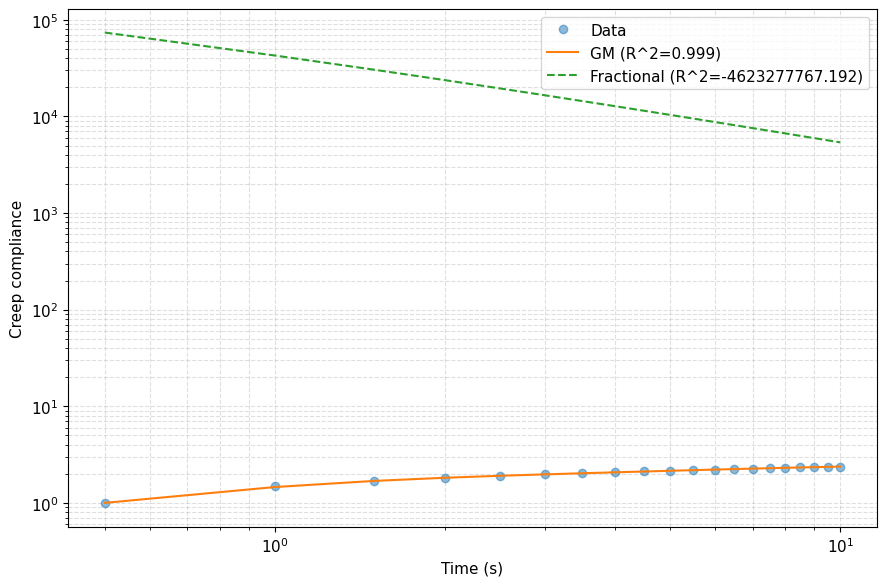

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, J, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Creep compliance')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.220112s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=7.507207e-04 | time=0.220s | final_gradient_norm=0.018299451847572607


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.229988s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=7.507207e-04 | time=0.230s | final_gradient_norm=0.018299451847572607


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.185453s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=5.275910e-03 | time=0.185s | final_gradient_norm=1.1038993892657375e-05


Element minimization: early termination at n_modes=1 (R²=0.995391 < threshold=0.999016)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 0.628157s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.999166e+00 | time=0.628s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 0.999), ('fm', -4623277767.192)]


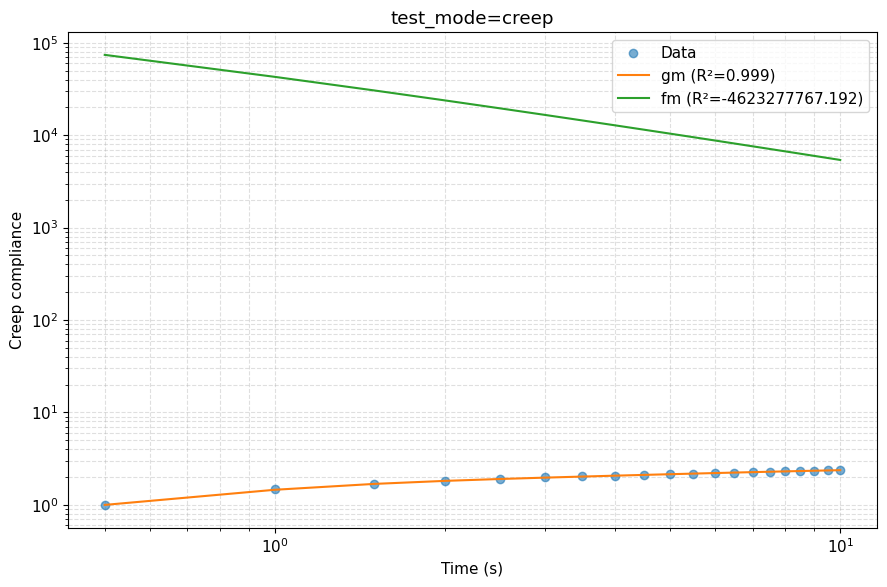

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<42:35,  1.56it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|▏         | 54/4000 [00:00<00:40, 97.51it/s, 1023 steps of size 7.46e-04. acc. prob=0.72]

warmup:   3%|▎         | 132/4000 [00:00<00:16, 237.33it/s, 511 steps of size 1.61e-02. acc. prob=0.76]

warmup:   9%|▉         | 361/4000 [00:00<00:05, 702.50it/s, 31 steps of size 1.01e-01. acc. prob=0.78] 

warmup:  15%|█▌        | 606/4000 [00:01<00:03, 1128.54it/s, 127 steps of size 4.28e-02. acc. prob=0.79]

warmup:  22%|██▏       | 885/4000 [00:01<00:02, 1556.85it/s, 63 steps of size 7.49e-02. acc. prob=0.79] 

sample:  29%|██▉       | 1150/4000 [00:01<00:01, 1850.96it/s, 63 steps of size 5.66e-02. acc. prob=0.94]

sample:  35%|███▌      | 1415/4000 [00:01<00:01, 2072.61it/s, 3 steps of size 5.66e-02. acc. prob=0.94] 

sample:  42%|████▏     | 1673/4000 [00:01<00:01, 2215.26it/s, 63 steps of size 5.66e-02. acc. prob=0.94]

sample:  48%|████▊     | 1931/4000 [00:01<00:00, 2319.96it/s, 63 steps of size 5.66e-02. acc. prob=0.94]

sample:  55%|█████▍    | 2192/4000 [00:01<00:00, 2402.25it/s, 63 steps of size 5.66e-02. acc. prob=0.94]

sample:  61%|██████▏   | 2451/4000 [00:01<00:00, 2456.27it/s, 63 steps of size 5.66e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2709/4000 [00:01<00:00, 2492.39it/s, 31 steps of size 5.66e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2978/4000 [00:01<00:00, 2548.60it/s, 63 steps of size 5.66e-02. acc. prob=0.94]

sample:  81%|████████  | 3237/4000 [00:02<00:00, 2542.04it/s, 63 steps of size 5.66e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3495/4000 [00:02<00:00, 2529.97it/s, 31 steps of size 5.66e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3758/4000 [00:02<00:00, 2557.46it/s, 51 steps of size 5.66e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1704.58it/s, 31 steps of size 5.66e-02. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 56/4000 [00:00<00:07, 549.78it/s, 1023 steps of size 2.59e-03. acc. prob=0.73]

warmup:   4%|▎         | 140/4000 [00:00<00:05, 716.48it/s, 127 steps of size 1.03e-01. acc. prob=0.77]

warmup:  10%|▉         | 386/4000 [00:00<00:02, 1505.60it/s, 63 steps of size 6.63e-02. acc. prob=0.78]

warmup:  16%|█▋        | 654/4000 [00:00<00:01, 1965.87it/s, 21 steps of size 1.23e-01. acc. prob=0.79]

warmup:  24%|██▍       | 962/4000 [00:00<00:01, 2365.59it/s, 39 steps of size 1.28e-01. acc. prob=0.79]

sample:  30%|██▉       | 1199/4000 [00:00<00:01, 2266.92it/s, 63 steps of size 4.41e-02. acc. prob=0.96]

sample:  36%|███▌      | 1427/4000 [00:00<00:01, 2241.97it/s, 127 steps of size 4.41e-02. acc. prob=0.95]

sample:  41%|████▏     | 1652/4000 [00:00<00:01, 2187.58it/s, 63 steps of size 4.41e-02. acc. prob=0.95] 

sample:  47%|████▋     | 1872/4000 [00:00<00:00, 2154.27it/s, 127 steps of size 4.41e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2088/4000 [00:01<00:00, 2135.48it/s, 95 steps of size 4.41e-02. acc. prob=0.95] 

sample:  58%|█████▊    | 2304/4000 [00:01<00:00, 2141.48it/s, 63 steps of size 4.41e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2519/4000 [00:01<00:00, 2143.49it/s, 127 steps of size 4.41e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2736/4000 [00:01<00:00, 2150.07it/s, 127 steps of size 4.41e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2952/4000 [00:01<00:00, 2134.56it/s, 31 steps of size 4.41e-02. acc. prob=0.95] 

sample:  79%|███████▉  | 3166/4000 [00:01<00:00, 2135.67it/s, 63 steps of size 4.41e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3380/4000 [00:01<00:00, 2121.94it/s, 31 steps of size 4.41e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3594/4000 [00:01<00:00, 2123.56it/s, 127 steps of size 4.41e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3807/4000 [00:01<00:00, 2119.65it/s, 63 steps of size 4.41e-02. acc. prob=0.95] 

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2068.59it/s, 19 steps of size 4.41e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 64/4000 [00:00<00:06, 634.10it/s, 791 steps of size 1.58e-03. acc. prob=0.74]

warmup:   4%|▍         | 168/4000 [00:00<00:04, 871.53it/s, 63 steps of size 1.15e-01. acc. prob=0.77]

warmup:  10%|█         | 405/4000 [00:00<00:02, 1553.47it/s, 63 steps of size 1.25e-01. acc. prob=0.78]

warmup:  17%|█▋        | 664/4000 [00:00<00:01, 1960.02it/s, 63 steps of size 7.78e-02. acc. prob=0.79]

warmup:  24%|██▍       | 957/4000 [00:00<00:01, 2307.45it/s, 63 steps of size 7.30e-02. acc. prob=0.79]

sample:  30%|██▉       | 1188/4000 [00:00<00:01, 2266.25it/s, 127 steps of size 4.03e-02. acc. prob=0.92]

sample:  35%|███▌      | 1415/4000 [00:00<00:01, 2247.21it/s, 51 steps of size 4.03e-02. acc. prob=0.92] 

sample:  41%|████      | 1640/4000 [00:00<00:01, 2245.23it/s, 63 steps of size 4.03e-02. acc. prob=0.92]

sample:  47%|████▋     | 1865/4000 [00:00<00:00, 2222.94it/s, 63 steps of size 4.03e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2088/4000 [00:01<00:00, 2217.23it/s, 15 steps of size 4.03e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2319/4000 [00:01<00:00, 2242.82it/s, 63 steps of size 4.03e-02. acc. prob=0.92]

sample:  64%|██████▎   | 2544/4000 [00:01<00:00, 2190.65it/s, 63 steps of size 4.03e-02. acc. prob=0.92]

sample:  69%|██████▉   | 2770/4000 [00:01<00:00, 2210.01it/s, 63 steps of size 4.03e-02. acc. prob=0.92]

sample:  75%|███████▍  | 2995/4000 [00:01<00:00, 2220.80it/s, 63 steps of size 4.03e-02. acc. prob=0.93]

sample:  80%|████████  | 3218/4000 [00:01<00:00, 2223.04it/s, 63 steps of size 4.03e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3441/4000 [00:01<00:00, 2218.43it/s, 63 steps of size 4.03e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3668/4000 [00:01<00:00, 2231.75it/s, 63 steps of size 4.03e-02. acc. prob=0.92]

sample:  97%|█████████▋| 3899/4000 [00:01<00:00, 2252.86it/s, 63 steps of size 4.03e-02. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2137.38it/s, 127 steps of size 4.03e-02. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 51/4000 [00:00<00:07, 508.56it/s, 511 steps of size 1.54e-03. acc. prob=0.73]

warmup:   3%|▎         | 102/4000 [00:00<00:07, 502.08it/s, 255 steps of size 4.23e-02. acc. prob=0.76]

warmup:   8%|▊         | 301/4000 [00:00<00:03, 1172.22it/s, 127 steps of size 4.15e-02. acc. prob=0.78]

warmup:  14%|█▍        | 561/4000 [00:00<00:01, 1730.61it/s, 63 steps of size 8.47e-02. acc. prob=0.79] 

warmup:  21%|██        | 846/4000 [00:00<00:01, 2130.15it/s, 47 steps of size 8.06e-02. acc. prob=0.79]

sample:  28%|██▊       | 1111/4000 [00:00<00:01, 2305.51it/s, 35 steps of size 5.83e-02. acc. prob=0.94]

sample:  34%|███▍      | 1374/4000 [00:00<00:01, 2410.52it/s, 15 steps of size 5.83e-02. acc. prob=0.94]

sample:  41%|████      | 1642/4000 [00:00<00:00, 2495.79it/s, 63 steps of size 5.83e-02. acc. prob=0.93]

sample:  47%|████▋     | 1896/4000 [00:00<00:00, 2508.19it/s, 127 steps of size 5.83e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2152/4000 [00:01<00:00, 2524.06it/s, 31 steps of size 5.83e-02. acc. prob=0.93] 

sample:  60%|██████    | 2413/4000 [00:01<00:00, 2549.49it/s, 31 steps of size 5.83e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2669/4000 [00:01<00:00, 2550.69it/s, 63 steps of size 5.83e-02. acc. prob=0.93]

sample:  74%|███████▎  | 2940/4000 [00:01<00:00, 2596.67it/s, 63 steps of size 5.83e-02. acc. prob=0.93]

sample:  80%|████████  | 3200/4000 [00:01<00:00, 2592.09it/s, 15 steps of size 5.83e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3461/4000 [00:01<00:00, 2597.01it/s, 63 steps of size 5.83e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3721/4000 [00:01<00:00, 2597.52it/s, 51 steps of size 5.83e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3983/4000 [00:01<00:00, 2601.09it/s, 63 steps of size 5.83e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2334.09it/s, 47 steps of size 5.83e-02. acc. prob=0.93]

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma'>,
        <Axes: xlabel='tau_1'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
        <Axes: title={'center': 'tau_1\n1'}>,
        <Axes: title={'center': 'tau_1\n2'}>,
        <Axes: title={'center': 'tau_1\n3'}>],
       [<Axes: title={'center': 'tau_2\n0'}>,
        <Axes: title={'center': 'tau_2\n1'}>,

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics
import arviz as az

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
